In [ ]:
from google.colab import files
uploaded = files.upload()


Saving updated_pollution_dataset.csv to updated_pollution_dataset.csv


Dataset Sample:
    Temperature  Humidity  PM2.5  PM10   NO2   SO2    CO  \
0         29.8      59.1    5.2  17.9  18.9   9.2  1.72   
1         28.3      75.6    2.3  12.2  30.8   9.7  1.64   
2         23.1      74.7   26.7  33.8  24.4  12.6  1.63   
3         27.1      39.1    6.1   6.3  13.5   5.3  1.15   
4         26.5      70.7    6.9  16.0  21.9   5.6  1.01   

   Proximity_to_Industrial_Areas  Population_Density Air Quality  
0                            6.3                 319    Moderate  
1                            6.0                 611    Moderate  
2                            5.2                 619    Moderate  
3                           11.1                 551        Good  
4                           12.7                 303        Good  

Model Accuracy: 86.2 %

Manual Classification Report:
 Class Moderate:
  Precision: 0.87
  Recall: 0.89
  F1-Score: 0.88

Class Good:
  Precision: 0.98
  Recall: 0.97
  F1-Score: 0.97

Class Hazardous:
  Precision: 0.81
  Rec

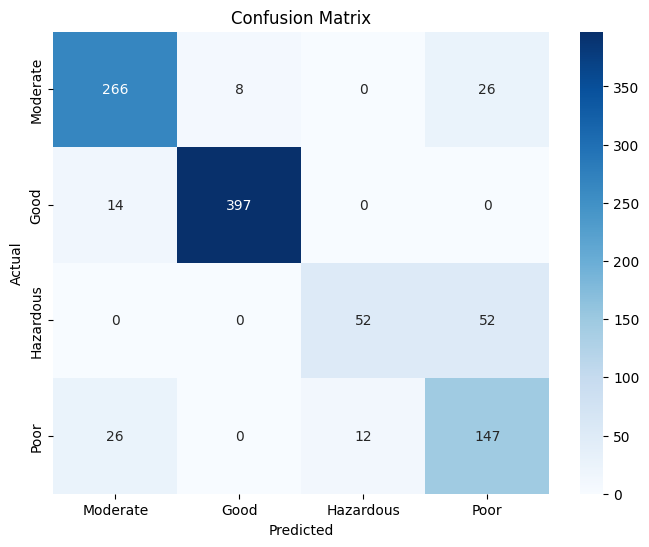

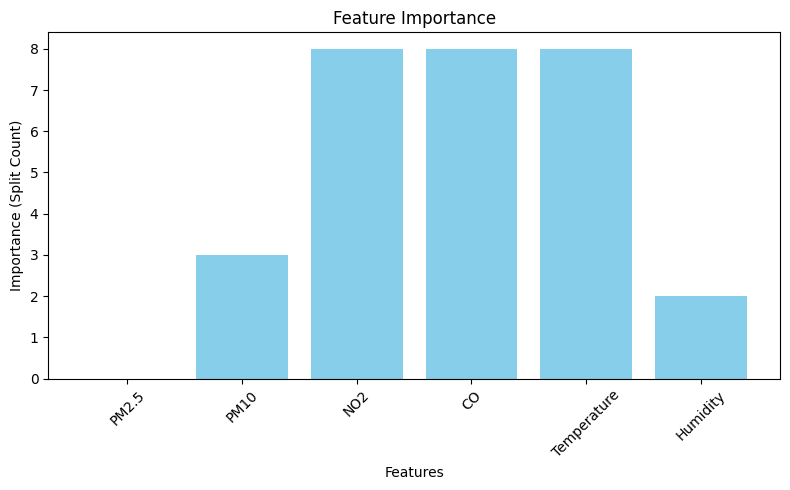


Decision Tree Structure:
Feature: CO <= -0.55
  Feature: NO2 <= 0.18
    Feature: CO <= -0.64
      Feature: Temperature <= -0.32
        Feature: PM10 <= -0.54
          Leaf: Good
          Leaf: Good
        Feature: NO2 <= -0.34
          Leaf: Good
          Leaf: Good
      Feature: Temperature <= -0.70
        Leaf: Good
        Feature: NO2 <= -0.38
          Leaf: Good
          Leaf: Moderate
    Feature: Humidity <= -0.04
      Feature: CO <= -0.81
        Feature: NO2 <= 0.31
          Leaf: Good
          Leaf: Moderate
        Feature: PM10 <= -0.77
          Leaf: Good
          Leaf: Moderate
      Feature: Temperature <= 0.68
        Leaf: Moderate
        Feature: PM10 <= -0.30
          Leaf: Moderate
          Leaf: Poor
  Feature: CO <= 0.57
    Feature: NO2 <= 0.86
      Feature: CO <= -0.33
        Feature: Temperature <= -0.39
          Leaf: Moderate
          Leaf: Moderate
        Feature: Humidity <= 1.46
          Leaf: Moderate
          Leaf: Poor
      

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "updated_pollution_dataset.csv"
df = pd.read_csv(file_path)

print("Dataset Sample:\n", df.head())

# Fill missing values only in numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Encode categorical 'Air Quality' (target variable)
labels = df["Air Quality"].unique()
label_dict = {label: idx for idx, label in enumerate(labels)}
inv_label_dict = {v: k for k, v in label_dict.items()}
df["Air Quality"] = df["Air Quality"].map(label_dict)

# Define features (X) and target (y)
features = ['PM2.5', 'PM10', 'NO2', 'CO', 'Temperature', 'Humidity']
X = df[features].values
y = df["Air Quality"].values

# Normalize numerical features (Standardization)
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Split dataset manually into training (80%) and testing (20%)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Function to compute entropy
def entropy(y):
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

# Function to split dataset
def split_dataset(X, y, feature_index, threshold):
    left_mask = X[:, feature_index] <= threshold
    right_mask = X[:, feature_index] > threshold
    return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

# Function to find the best split
def best_split(X, y):
    best_feature, best_threshold, best_gain = None, None, -1
    current_entropy = entropy(y)

    for feature_index in range(X.shape[1]):
        thresholds = np.unique(X[:, feature_index])
        for threshold in thresholds:
            X_left, y_left, X_right, y_right = split_dataset(X, y, feature_index, threshold)
            if len(y_left) == 0 or len(y_right) == 0:
                continue

            weighted_entropy = (len(y_left) / len(y) * entropy(y_left) +
                                len(y_right) / len(y) * entropy(y_right))
            information_gain = current_entropy - weighted_entropy

            if information_gain > best_gain:
                best_feature, best_threshold, best_gain = feature_index, threshold, information_gain

    return best_feature, best_threshold

# Decision Tree Node class
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

# Recursive function to build decision tree
def build_tree(X, y, depth=0, max_depth=5):
    if len(set(y)) == 1:
        return Node(value=y[0])

    if depth >= max_depth:
        return Node(value=Counter(y).most_common(1)[0][0])

    best_feature, best_threshold = best_split(X, y)
    if best_feature is None:
        return Node(value=Counter(y).most_common(1)[0][0])

    X_left, y_left, X_right, y_right = split_dataset(X, y, best_feature, best_threshold)
    left_subtree = build_tree(X_left, y_left, depth + 1, max_depth)
    right_subtree = build_tree(X_right, y_right, depth + 1, max_depth)

    return Node(feature=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree)

# Function to predict single instance
def predict(tree, x):
    if tree.value is not None:
        return tree.value
    if x[tree.feature] <= tree.threshold:
        return predict(tree.left, x)
    else:
        return predict(tree.right, x)

# Train the Decision Tree
decision_tree = build_tree(X_train, y_train, max_depth=5)

# Make predictions
y_pred = np.array([predict(decision_tree, x) for x in X_test])

# Evaluate accuracy
accuracy = np.mean(y_pred == y_test)
print("\nModel Accuracy:", round(accuracy * 100, 2), "%")

# Confusion matrix implementation
def confusion_matrix(y_true, y_pred, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(y_true, y_pred):
        matrix[true][pred] += 1
    return matrix

# Classification report (manual)
def classification_report_manual(y_true, y_pred, num_classes):
    report = ""
    for cls in range(num_classes):
        tp = sum((y_pred == cls) & (y_true == cls))
        fp = sum((y_pred == cls) & (y_true != cls))
        fn = sum((y_pred != cls) & (y_true == cls))

        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        report += f"Class {inv_label_dict[cls]}:\n  Precision: {precision:.2f}\n  Recall: {recall:.2f}\n  F1-Score: {f1:.2f}\n\n"
    return report

num_classes = len(np.unique(y))
print("\nManual Classification Report:\n", classification_report_manual(y_test, y_pred, num_classes))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred, num_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Feature importance by counting usage during splits
def compute_feature_importance(tree, feature_importance):
    if tree.value is not None:
        return
    feature_importance[tree.feature] += 1
    compute_feature_importance(tree.left, feature_importance)
    compute_feature_importance(tree.right, feature_importance)

feature_importance = [0] * len(features)
compute_feature_importance(decision_tree, feature_importance)

plt.figure(figsize=(8,5))
plt.bar(features, feature_importance, color="skyblue")
plt.xlabel("Features")
plt.ylabel("Importance (Split Count)")
plt.title("Feature Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Textual representation of decision tree
def print_tree(node, depth=0):
    if node.value is not None:
        print("  " * depth + f"Leaf: {inv_label_dict[node.value]}")
    else:
        print("  " * depth + f"Feature: {features[node.feature]} <= {node.threshold:.2f}")
        print_tree(node.left, depth + 1)
        print_tree(node.right, depth + 1)

print("\nDecision Tree Structure:")
print_tree(decision_tree)



Training with max_depth = 3

Training with max_depth = 5

Training with max_depth = 7

📊 Metrics Comparison Table:
Depth     Accuracy  Precision   Recall    F1-Score  
3         0.841     0.779       0.782     0.78      
5         0.862     0.829       0.787     0.797     
7         0.885     0.845       0.824     0.831     


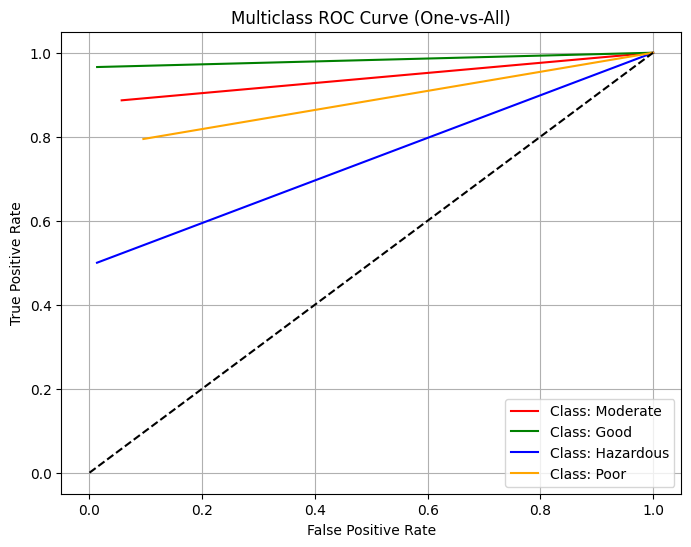

In [ ]:
# Evaluate at multiple tree depths
depths = [3, 5, 7]
metrics_table = []

for depth in depths:
    print(f"\nTraining with max_depth = {depth}")
    tree = build_tree(X_train, y_train, max_depth=depth)
    y_pred = np.array([predict(tree, x) for x in X_test])

    # Compute metrics
    accuracy = np.mean(y_pred == y_test)
    num_classes = len(np.unique(y))
    precision_list, recall_list, f1_list = [], [], []

    for cls in range(num_classes):
        tp = sum((y_pred == cls) & (y_test == cls))
        fp = sum((y_pred == cls) & (y_test != cls))
        fn = sum((y_pred != cls) & (y_test == cls))

        precision = tp / (tp + fp) if (tp + fp) else 0
        recall = tp / (tp + fn) if (tp + fn) else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)

    metrics_table.append({
        "Depth": depth,
        "Accuracy": round(accuracy, 3),
        "Precision": round(avg_precision, 3),
        "Recall": round(avg_recall, 3),
        "F1-Score": round(avg_f1, 3)
    })

# Print metrics comparison table
print("\n📊 Metrics Comparison Table:")
print("{:<10}{:<10}{:<12}{:<10}{:<10}".format("Depth", "Accuracy", "Precision", "Recall", "F1-Score"))
for row in metrics_table:
    print("{:<10}{:<10}{:<12}{:<10}{:<10}".format(row["Depth"], row["Accuracy"], row["Precision"], row["Recall"], row["F1-Score"]))

# ROC Curve (One-vs-All for Multiclass)
def compute_roc(y_true, y_pred_scores, num_classes):
    fpr_dict, tpr_dict = {}, {}
    for cls in range(num_classes):
        y_true_binary = (y_true == cls).astype(int)
        y_scores = y_pred_scores[:, cls]

        thresholds = np.linspace(1, 0, 100)
        tpr_list, fpr_list = [], []

        for thresh in thresholds:
            y_pred_bin = (y_scores >= thresh).astype(int)
            tp = np.sum((y_pred_bin == 1) & (y_true_binary == 1))
            fp = np.sum((y_pred_bin == 1) & (y_true_binary == 0))
            fn = np.sum((y_pred_bin == 0) & (y_true_binary == 1))
            tn = np.sum((y_pred_bin == 0) & (y_true_binary == 0))

            tpr = tp / (tp + fn) if (tp + fn) else 0
            fpr = fp / (fp + tn) if (fp + tn) else 0

            tpr_list.append(tpr)
            fpr_list.append(fpr)

        fpr_dict[cls] = fpr_list
        tpr_dict[cls] = tpr_list

    return fpr_dict, tpr_dict

# Use best model (depth=5) for ROC
best_tree = build_tree(X_train, y_train, max_depth=5)
# Get prediction scores (counts of class votes)
def predict_proba(tree, x, num_classes):
    counts = [0] * num_classes
    def traverse(node):
        if node.value is not None:
            counts[node.value] += 1
        else:
            if x[node.feature] <= node.threshold:
                traverse(node.left)
            else:
                traverse(node.right)
    traverse(tree)
    total = sum(counts)
    return np.array(counts) / total if total > 0 else np.ones(num_classes) / num_classes

y_score = np.array([predict_proba(best_tree, x, num_classes) for x in X_test])
fpr_dict, tpr_dict = compute_roc(y_test, y_score, num_classes)

# Plot ROC curves
plt.figure(figsize=(8,6))
colors = ["red", "green", "blue", "orange", "purple", "cyan"]
for cls in range(num_classes):
    plt.plot(fpr_dict[cls], tpr_dict[cls], label=f"Class: {inv_label_dict[cls]}", color=colors[cls % len(colors)])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (One-vs-All)")
plt.legend()
plt.grid()
plt.show()
